In [15]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import os
import pandas as pd
import librosa

In [22]:
raw_data = pd.read_pickle("Res/df_10000_sp_random.pkl")
sr = 22050
hop_length = 396
fft_size = 2048
n_mels = 224
images = np.zeros([raw_data["audio"].size, 1, 224, 224])
parameters = np.zeros([raw_data["audio"].size, 281])


for i in range(raw_data["audio"].size):
    audio = raw_data["audio"][i]
    param = raw_data["param"][i].all()

    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=fft_size, hop_length=hop_length, n_mels=n_mels)
    mel_spectrogram_dB = librosa.power_to_db(mel_spectrogram, ref=np.max)
    images[i, 0, :, :] = mel_spectrogram_dB
    parameters[i, :] = list(param.values())


In [ ]:
# Flatten and standardize images
flattened_images = images.reshape(images.shape[0], -1)
standardized_images = StandardScaler().fit_transform(flattened_images)

In [105]:
non_constant_indices = np.where(np.std(parameters, axis=0) != 0)[0]

(106,)


In [106]:
# Perform PCA
n_components = 200
pca = PCA(n_components=n_components)
pca_images = pca.fit_transform(standardized_images)

# Calculate correlations between input parameters and PCs
num_parameters = parameters.shape[1]
num_pcs = pca_images.shape[1]
correlations = np.zeros((num_parameters, num_pcs))

for i in range(num_parameters):
    for j in range(num_pcs):
        correlations[i, j] = pearsonr(parameters[:, i], pca_images[:, j])[0]

# Print the correlations
correlations = correlations.T

/Users/collinfeng/opt/anaconda3/envs/playground/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


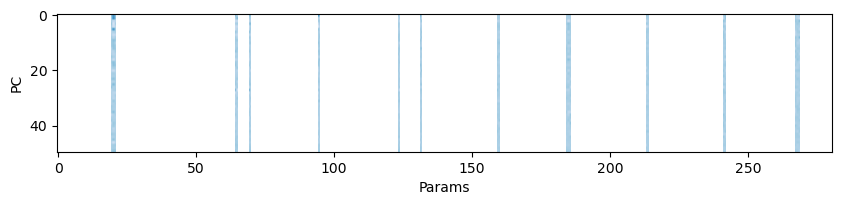

In [103]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.xlabel("Params")
plt.ylabel("PC")
plt.imshow(correlations, cmap='Blues')


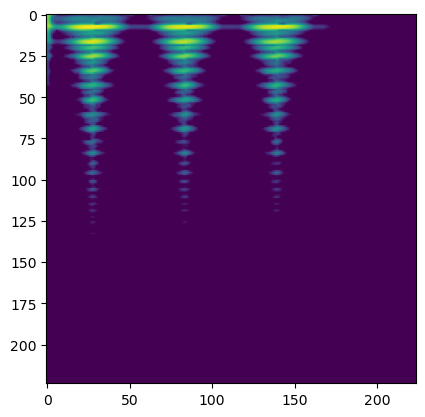

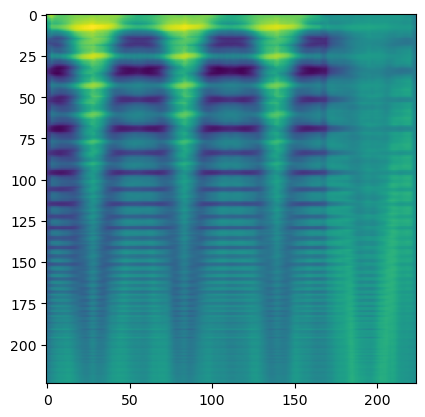

In [53]:
img0_pc = pca_images[0, :]
img0_reconstructed = pca.inverse_transform(img0_pc)
img0_reconstructed = img0_reconstructed.reshape(224, 224)
plt.figure()
plt.imshow(images[0,::].reshape(224, 224))
plt.figure()
plt.imshow(img0_reconstructed)

In [101]:
correlations_eval = np.sum(correlations, axis=0)
correlations_eval[np.isnan(correlations_eval)] = 0
top_indices = np.argsort(correlations_eval)[-64:][::-1]
top_param = []
keys_lst = list(param.keys())
for index in top_indices:
    if correlations_eval[index] != 0:
        top_param.append(keys_lst[index])
top_param.sort()


In [102]:
top_param


['Chrs1: Depth',
 'Chrs1: Rate',
 'Chrs1: Wet',
 'ENV1: Attack',
 'ENV1: Decay',
 'ENV1: Sustain',
 'ENV2: Attack',
 'ENV2: Decay',
 'ENV2: Release',
 'LFO1: Rate',
 'LFO2: Phase',
 'LFO2: Rate',
 'MOD: Slew Rate',
 'OSC: DigitalShape2',
 'OSC: DigitalShape4',
 'OSC: OscMix',
 'OSC: PWModDepth',
 'OSC: Shape3',
 'OSC: Tune1ModDepth',
 'OSC: Tune3',
 'OSC: Volume1',
 'Plate1: Diffusion',
 'Plate1: Wet',
 'VCA1: ModDepth',
 'VCA1: PanModDepth',
 'VCF1: FilterFM',
 'VCF1: FmAmountModDepth',
 'VCF1: FreqMod2Depth',
 'VCF1: Frequency',
 'VCF1: ResModDepth',
 'VCF1: Resonance']

In [43]:
print(param)

{'Chrs1: Wet': 1.0, 'HPF: FreqModSrc': 0.0, 'ENV2: Curve': 0.0, 'OSC: Tune1ModSrc': 0.6521739130434783, 'OSC: PulseShape': 0.3333333333333333, 'PCore: LED Colour': 0.0, 'OSC: ShapeModOsc3': 0.0, 'Scope1: Frequency': 0.2, 'OSC: Noise1On': 0.0, 'HPF: Model': 0.0, 'Delay2: HP': 0.0, 'FX2: Module': 0.75, 'OSC: TuneModOsc2': 0.0, 'main: Active #FX1': 0.0, 'HPF: KeyFollow': 0, 'Phase2: Wet': 1.0, 'Delay1: Side Vol': 0.2, 'Delay1: Left Delay': 0.06666666666666667, 'Rtary2: Mode': 0.0, 'Rtary1: Drive': 0.77, 'ENV2: Attack': 0.0, 'ENV1: KeyFollow': 0.0, 'VCF1: SvfMode': 0.0, 'OSC: NoiseVolModSrc': 0.0, 'VCA1: VCA': 1.0, 'OSC: NoiseColor': 0.0, 'Plate2: Dry': 0.9, 'ENV2: Quantise': 0.0, 'Delay2: Wow': 0.5, 'HPF: FreqModDepth': 0.5, 'Chrs2: Wet': 1.0, 'VCC: Transpose': 0.5, 'Rtary2: Slow': 0.3, 'VCF1: FreqMod2Depth': 0.5, 'HPF: Post-HPF Freq': 0.25, 'ENV2: Model': 0.5, 'ENV1: Decay': 0.285, 'VCF1: ResModSrc': 0.0, 'OSC: Tune2': 0.1, 'OSC: Model': 0.0, 'MOD: MulSource1': 0.0, 'CLK: TimeBase': 0.66

In [6]:
explained_variance_ratios = pca.explained_variance_ratio_
print("Explained variance ratios:", explained_variance_ratios)
cumulative_explained_variance = np.cumsum(explained_variance_ratios)
print("Cumulative explained variance:", cumulative_explained_variance)

Explained variance ratios: [0.40420821 0.10144432 0.08173198 0.04021647 0.03904769 0.0295796
 0.02128744 0.01746618 0.01455521 0.00956057 0.00837483 0.00802612
 0.00773102 0.0066626  0.00597494 0.00571727 0.00562739 0.00534353
 0.00474062 0.00431545 0.00423478 0.00407068 0.00351884 0.00338772
 0.00317715 0.00308876 0.0030034  0.00278617 0.00273098 0.00255318
 0.00252414 0.00247473 0.00233731 0.00226765 0.00218656 0.00215408
 0.00206977 0.00199014 0.00190482 0.0018681  0.00182261 0.0017723
 0.00167995 0.00161959 0.00155775 0.00152308 0.00147045 0.00141697
 0.00138612 0.00136076]
Cumulative explained variance: [0.40420821 0.50565253 0.58738451 0.62760098 0.66664866 0.69622826
 0.7175157  0.73498188 0.74953709 0.75909766 0.76747249 0.77549861
 0.78322963 0.78989223 0.79586717 0.80158443 0.80721182 0.81255535
 0.81729597 0.82161143 0.82584621 0.82991688 0.83343572 0.83682344
 0.8400006  0.84308936 0.84609275 0.84887892 0.8516099  0.85416308
 0.85668721 0.85916194 0.86149925 0.8637669  0.86